In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import warnings
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA

sns.set()
warnings.filterwarnings('ignore')

In [21]:
train_logs = pd.read_csv('input/train_logs.csv')
train_scores = pd.read_csv('input/train_scores.csv')
train_logs.head(2)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0


In [31]:
train_logs.groupby('cursor_position')['event_id'].agg('count')

cursor_position
0       38765
1        6714
2        5722
3        5505
4        5363
        ...  
7798        1
7799        1
7800        1
7801        1
7802        1
Name: event_id, Length: 7803, dtype: int64

In [47]:
essays = pd.DataFrame()
essays['id'] = train_scores['id']
essays['score'] = train_scores['score']
g = train_logs.groupby(['id'])['event_id'].agg('count')
essays['total_events'] = g.values

events = [',', '-', '.', '(', 'Leftclick', 'CapsLock', '"', '?', "'", '\\', 'Enter']
g = train_logs.groupby(['id', 'down_event']).count().unstack(fill_value=0).stack()
for event in events:
    essays[event + '_freq'] =  g[g.index.get_level_values('down_event') == event]['event_id'].values / essays['total_events']

activities = ['Replace']
g = train_logs.groupby(['id', 'activity']).count().unstack(fill_value=0).stack()
for activity in activities:
    essays[activity + '_freq'] =  g[g.index.get_level_values('activity') == activity]['event_id'].values / essays['total_events']

cpos = [0, 1, 4, 10, 15, 20, 50, 100, 200, 500, 1000]
g = train_logs.groupby(['id', 'cursor_position']).count().unstack(fill_value=0).stack()
for pos in cpos:
    essays[str(pos) + '_freq'] =  g[g.index.get_level_values('cursor_position') == pos]['event_id'].values / essays['total_events']

g = train_logs.groupby(['id'])['word_count'].agg('max')
essays['max_count'] = g.values
essays.head()

,id,score,total_events,",_freq",-_freq,._freq,(_freq,Leftclick_freq,CapsLock_freq,"""_freq",...,4_freq,10_freq,15_freq,20_freq,50_freq,100_freq,200_freq,500_freq,1000_freq,max_count
0,001519c8,3.5,2557,0.004693,0.000000,0.008213,0.0,0.035980,0.000000,0.000000,...,0.000782,0.000782,0.001173,0.001173,0.000782,0.000391,0.000782,0.000391,0.000391,256
1,0022f953,3.5,2454,0.008557,0.002037,0.006112,0.0,0.022820,0.000000,0.002445,...,0.000407,0.001222,0.001222,0.001222,0.000407,0.001222,0.000407,0.001630,0.000815,323
2,0042269b,6.0,4136,0.005561,0.000242,0.005077,0.0,0.031190,0.000000,0.000484,...,0.000484,0.000484,0.000725,0.000725,0.001209,0.001209,0.000725,0.000725,0.000484,404
3,0059420b,2.0,1556,0.001928,0.000000,0.008355,0.0,0.011568,0.001285,0.000000,...,0.000643,0.000643,0.000643,0.001285,0.000643,0.001285,0.000643,0.000643,0.000643,206
4,0075873a,4.0,2531,0.009482,0.000000,0.009087,0.0,0.013038,0.000000,0.000000,...,0.000395,0.000395,0.000395,0.000395,0.000395,0.000790,0.000790,0.000395,0.000395,252


In [48]:
data_cols = [str(e) + '_freq' for e in events + activities + cpos] + ['max_count']

data = pd.DataFrame()
data['features'] = data_cols
data['VIF'] = [variance_inflation_factor(essays[data_cols], i).round(1) for i in range(essays[data_cols].shape[1])]
f_scores, p_scores = f_regression(essays[data_cols], essays['score'])
data['Fscores'] = f_scores.round(0)
data['Pscores'] = p_scores.round(5)
data = data.sort_values(by='Fscores', ascending=False)
data

,features,VIF,Fscores,Pscores
23,max_count,5.0,1677.0,0.00000
0,",_freq",4.7,467.0,0.00000
17,20_freq,4.5,258.0,0.00000
15,10_freq,5.0,253.0,0.00000
13,1_freq,3.0,243.0,0.00000
22,1000_freq,2.3,176.0,0.00000
1,-_freq,1.5,153.0,0.00000
2,._freq,6.1,149.0,0.00000
18,50_freq,2.1,140.0,0.00000
21,500_freq,1.9,126.0,0.00000


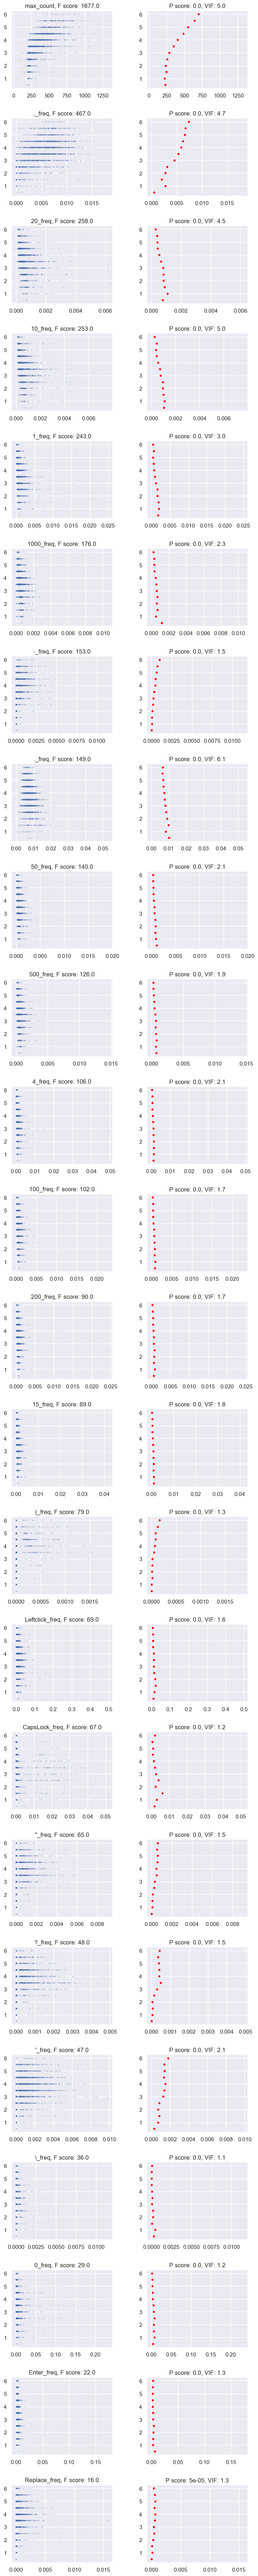

In [49]:
n = len(data_cols)
fig, axs = plt.subplots(ncols=2, nrows=n, figsize=(8, 3 * n), sharex='row')
fig.tight_layout(pad=3.0)

for i in range(n):
    col = data['features'].iloc[i]
    g = essays.groupby('score')[col].agg('mean')
    axs[i, 0].scatter(essays[col], essays['score'], s=3, alpha=.1)
    axs[i, 0].title.set_text(col + ', F score: ' + str(data['Fscores'].iloc[i]))
    axs[i, 1].scatter(g, g.index, s=10, color='red')
    axs[i, 1].title.set_text('P score: ' + str(data['Pscores'].iloc[i]) + ', VIF: ' + str(data['VIF'].iloc[i]) )

In [68]:
X, y = essays[data_cols], essays['score']
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=.25, random_state=20)

In [51]:
def round_scores(scores):
    scores = ((scores * 2) // 1) * .5
    scores = np.where(scores < 0, 0.0, scores)
    scores = np.where(scores > 6, 6.0, scores)
    return scores

MAE: training set
0.6735057434831
MAE: validation set
0.7608859102526822


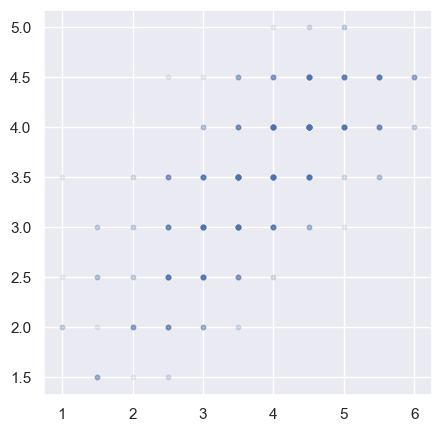

In [69]:
model = GradientBoostingRegressor(max_depth=2, min_samples_leaf=4, n_estimators=50, learning_rate=.1, subsample=.5)
model.fit(X_train, y_train)
y_predict_train = round_scores(model.predict(X_train))
y_predict_valid = round_scores(model.predict(X_valid))
print('MAE: training set')
print(mean_squared_error(y_train, y_predict_train, squared=False))
print('MAE: validation set')
print(mean_squared_error(y_valid, y_predict_valid, squared=False))
plt.figure(figsize=(5,5))
plt.scatter(y_valid, y_predict_valid, s=10, alpha=.1);